# Fuzzy Water Observations from Space <img align="right" src="../../../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[wofs_albers](https://explorer.sandbox.dea.ga.gov.au/wofs_albers), 
[ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls7e_ard_3),
[DEA Waterbodies](https://www.ga.gov.au/dea/products/dea-waterbodies)

## Description

This notebook demonstrates FuzzyWOfS, a reimplementation of [the WOfS classifier](https://github.com/GeoscienceAustralia/wofs/blob/master/wofs/classifier.py) over distributions. FuzzyWOfS estimates the probability that each pixel in a Landsat image is wet.

We will:

1. Show how to visualise the FuzzyWOfS classifier;
2. Show how to use FuzzyWOfS to find the probability that each pixel in a Landsat image is wet;
3. Compare the FuzzyWOfS results to MNDWI and TCW, which are band indices often used to estimate wetness.

***

## Getting started

Choose a waterbody in the "Analysis parameters" section and then run all cells.

### Load packages
Import Python packages that are used for the analysis.

In [39]:
%matplotlib inline

import sys
import datacube
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.colors

sys.path.append("../../../Scripts")
from dea_plotting import rgb
from dea_datahandling import mostcommon_crs
from dea_waterbodies import get_waterbody
from dea_bandindices import calculate_indices

import fuzzy_wofs

### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [40]:
dc = datacube.Datacube(app="FuzzyWOfS")

### Analysis parameters

Specify the geohash for a waterbody:

In [42]:
geohash = 'r38psere6'  # Lake Cullivel

A product:

In [43]:
product = "ga_ls7e_ard_3"

A date with observations:

In [44]:
date = '2002-02-21'  # Lake Cullivel

And a buffer radius in metres:

In [45]:
buffer = 500

### Load the waterbody polygon

In [47]:
wb = get_waterbody(geohash)

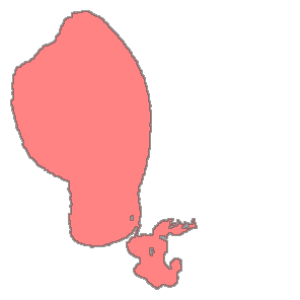

In [48]:
wb.geometry[0]

## Load the image to classify

We'll load a Landsat image to apply FuzzyWOfS to. Set up the waterbody polygon so we can use it to query:

In [49]:
gpg = datacube.utils.geometry.Geometry(wb.geometry[0], crs=wb.crs)

Identify the correct CRS for the output:

In [13]:
best_crs = mostcommon_crs(dc, product=product, query=dict(geopolygon=gpg, time=date))

Query the Landsat image:

In [50]:
bands = [
    "nbart_blue",
    "nbart_green",
    "nbart_red",
    "nbart_nir",
    "nbart_swir_1",
    "nbart_swir_2",
]

In [51]:
da = dc.load(
    product,
    geopolygon=datacube.utils.geometry.Geometry(wb.geometry[0].buffer(buffer), crs=wb.crs),
    time=date,
    output_crs=best_crs,
    resolution=(-30, 30),
    resampling="cubic",
    measurements=bands + ["fmask"],
)

Then we can have a look at the image.

In [52]:
landsat = da.isel(time=0)

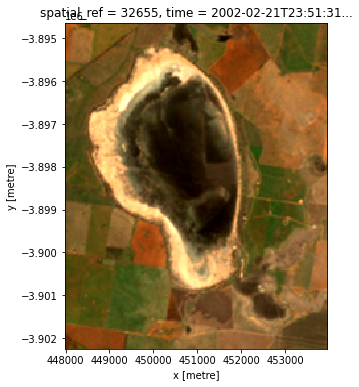

In [53]:
rgb(landsat)

## Defining the decision tree

We'll start by defining a single FuzzyWOfS node, and then build a tree out of it. We can then easily implement FuzzyWOfS using this tree.

In [18]:
class FuzzyWOfSLeaf:
    LEAF_ID = 0

    def __init__(self, wet_prob, n_wet, n_dry=None):
        self.wet_prob = wet_prob
        self.id = FuzzyWOfSLeaf.LEAF_ID
        FuzzyWOfSLeaf.LEAF_ID += 1
        if n_dry is not None:
            self.n_wet = n_wet
            self.n_dry = n_dry
        else:
            self.n_wet = int(n_wet * wet_prob)
            self.n_dry = n_wet - self.n_wet
        self.colour = 'blue' if wet_prob > 0.5 else 'red'
    
    def __repr__(self):
        return f'p(wet={self.wet_prob:.02f})'
    
    def predict(self, values):
        return self.wet_prob > 0.5
    
    def fuzzy_predict(self, means, stdevs, hard_edges=False):
        if not hard_edges:
            return self.wet_prob
        return self.wet_prob > 0.5
    
    def to_string(self):
        return f'{self.wet_prob:.02f}'
    
    def count(self):
        return self.n_wet, self.n_dry
    
    def get_leaf(self, values):
        return self.id
    
    def name(self):
        confidence = self.wet_prob if self.wet_prob > 0.5 else 1 - self.wet_prob
        return f'LEAF {self.id}\n{confidence:.02%}'
    
    def build_graphviz(self, dot):
        return
    
class FuzzyWOfSNode:
    MEASUREMENTS = {
        'tm1': 0,
        'tm2': 1,
        'tm3': 2,
        'tm4': 3,
        'tm5': 4,
        'tm7': 5,
        'ndi52': 6,
        'ndi43': 7,
        'ndi72': 8,
    }
    
    MEASUREMENT_NAMES = [
        'tm1',
        'tm2',
        'tm3',
        'tm4',
        'tm5',
        'tm7',
        'ndi52',
        'ndi43',
        'ndi72',
    ]
    
    NODE_ID = 0
    
    @staticmethod
    def band_ratio(a, b):
        """
        Calculates a normalised ratio index.
        """
        c = (a - b) / (a + b)
        return c
    
    @staticmethod
    def landsat_values(px):
        ndi_52 = FuzzyWOfSNode.band_ratio(px[4], px[1])
        ndi_43 = FuzzyWOfSNode.band_ratio(px[3], px[2])
        ndi_72 = FuzzyWOfSNode.band_ratio(px[5], px[1])

        b1 = px[0]
        b2 = px[1]
        b3 = px[2]
        b4 = px[3]
        b5 = px[4]
        b7 = px[5]
        
        return np.stack([b1, b2, b3, b4, b5, b7, ndi_52, ndi_43, ndi_72])

    def __init__(self, split_feature, split_value, left_child, right_child):
        self.left_child = left_child
        self.right_child = right_child
        self.split_feature = split_feature
        self.split_value = split_value
        self.split_index = self.MEASUREMENTS[self.split_feature]
        self.id = FuzzyWOfSNode.NODE_ID
        FuzzyWOfSNode.NODE_ID += 1
        self.colour = 'white'
    
    def __repr__(self):
        return f'FuzzyWOfSNode({self.split_feature} @ {self.split_value:.02f})'
    
    def predict(self, values):
        left = self.left_child.predict(values)
        right = self.right_child.predict(values)
        return np.where(values[self.split_index] <= self.split_value,
                        left,
                        right)
    
    def fuzzy_predict(self, means, stdevs, hard_edges=False):
        left = self.left_child.fuzzy_predict(means, stdevs, hard_edges=hard_edges)
        right = self.right_child.fuzzy_predict(means, stdevs, hard_edges=hard_edges)
        mean = means[self.split_index]
        stdev = stdevs[self.split_index]
        
        # How much of the Gaussian goes into the left subtree?
        # Integrate G(x) from -inf to split value.
        weight = scipy.special.erf((mean - self.split_value) / stdev)
        # If the split value is much greater than the mean, then we almost surely go down the left tree.
        # The weight becomes -1.
        # Conversely, if the split value is much much less than the mean, then we almost surely go down the right tree.
        # The weight becomes 1.
        # If we add 1 and halve, our numbers map from 0 (all left) to 1 (all right).
        weight = (weight + 1) / 2
        if hard_edges:
            weight = (mean - self.split_value) / stdev > 0
        return left * (1 - weight) + right * weight
    
    def to_string(self):
        means = [f'mu_{m}' for m in self.MEASUREMENT_NAMES]
        stdevs = [f'sigma_{m}' for m in self.MEASUREMENT_NAMES]
    
        left = self.left_child.to_string()
        right = self.right_child.to_string()

        mean = means[self.split_index]
        stdev = stdevs[self.split_index]
        
        weight = f'(erf(({mean} - {self.split_value}) / {stdev}) + 1) / 2'
        return f'({left}) * (1 - {weight}) + ({right}) * {weight}'
    
    def count(self):
        if hasattr(self, '_count'):
            return self._count
        lw, ld = self.left_child.count()
        rw, rd = self.right_child.count()
        self._count = (lw + rw, ld + rd)
        return (lw + rw, ld + rd)
    
    def get_leaf(self, values):
        left = self.left_child.get_leaf(values)
        right = self.right_child.get_leaf(values)
        return np.where(values[self.split_index] <= self.split_value,
                        left,
                        right)
    
    def name(self):
        return f'NODE {self.id} n={self.count()}'
    
    def build_graphviz(self, dot=None):
        if dot is None:
            dot = Digraph()

        # Make left child.
        dot.node(name=self.left_child.name(), label=self.left_child.name(), color=self.left_child.colour)
        dot.edge(self.name(), self.left_child.name())
        self.left_child.build_graphviz(dot)

        # Make right child.
        node = dot.node(name=self.right_child.name(), label=self.right_child.name(), color=self.right_child.colour)
        dot.edge(self.name(), self.right_child.name())
        self.right_child.build_graphviz(dot)
        
        return dot

## WOfS implementation

We can then implement WOfS as a decision tree.

In [19]:
Leaf = FuzzyWOfSLeaf
Node = FuzzyWOfSNode

# Left subtree.
left = Node('tm1', 2083.5,
           Node('tm7', 323.5,
               Node('ndi43', 0.61,
                    Leaf(0.972, 44615),
                    Leaf(0.000, 173)),
               Node('tm1', 1400.5,
                    Node('ndi72', -0.23,
                         Node('ndi43', 0.22,
                              Leaf(0.786, 5264),
                              Node('tm1', 473.0,
                                   Leaf(0.978, 360),
                                   Leaf(1 - 0.967, 869))),
                         Node('tm1', 379.0,
                              Leaf(0.831, 160),
                              Leaf(1 - 0.988, 1954))),
                   Node('ndi43', -0.01,
                        Leaf(0.977, 257),
                        Leaf(0.003, 2810)))),
           Leaf(0.001, 6683))

# Right subtree.
right = Node('ndi52', 0.23,
             Node('tm1', 334.5,
                  Node('ndi43', 0.54,
                       Node('ndi52', 0.12,  # Typo in the paper here.
                            Leaf(0.801, 2467),
                            Node('tm3', 364.5,
                                 Node('tm1', 129.5,
                                      Leaf(0.632, 484),
                                      Leaf(1 - 0.902, 1727)),
                                 Node('tm1', 300.5,
                                      Leaf(0.757, 889),
                                      Leaf(1 - 0.885, 358)))),
                       Leaf(1 - 0.974, 4503)),
                  Leaf(1 - 0.981, 12441)),
             Node('ndi52', 0.34,
                  Node('tm1', 249.5,
                       Node('ndi43', 0.45,
                            Node('tm3', 364.5,
                                 Node('tm1', 129.5,
                                      Leaf(0.616, 185),
                                      Leaf(1 - 0.940, 1072)),
                                 Leaf(0.584, 620)),
                            Leaf(1 - 0.979, 5703)),
                       Leaf(1 - 0.984, 10034)),
                  Leaf(1 - 0.996, 80246)))

# All together:
wofs_tree = Node('ndi52', -0.01, left, right)


# wofs_tree = Node('ndi52', -0.01, Leaf(1 - 0.288), Leaf(0.288))

In [20]:
wofs_tree = fuzzy_wofs.wofs

In [21]:
dot = wofs_tree.build_graphviz()

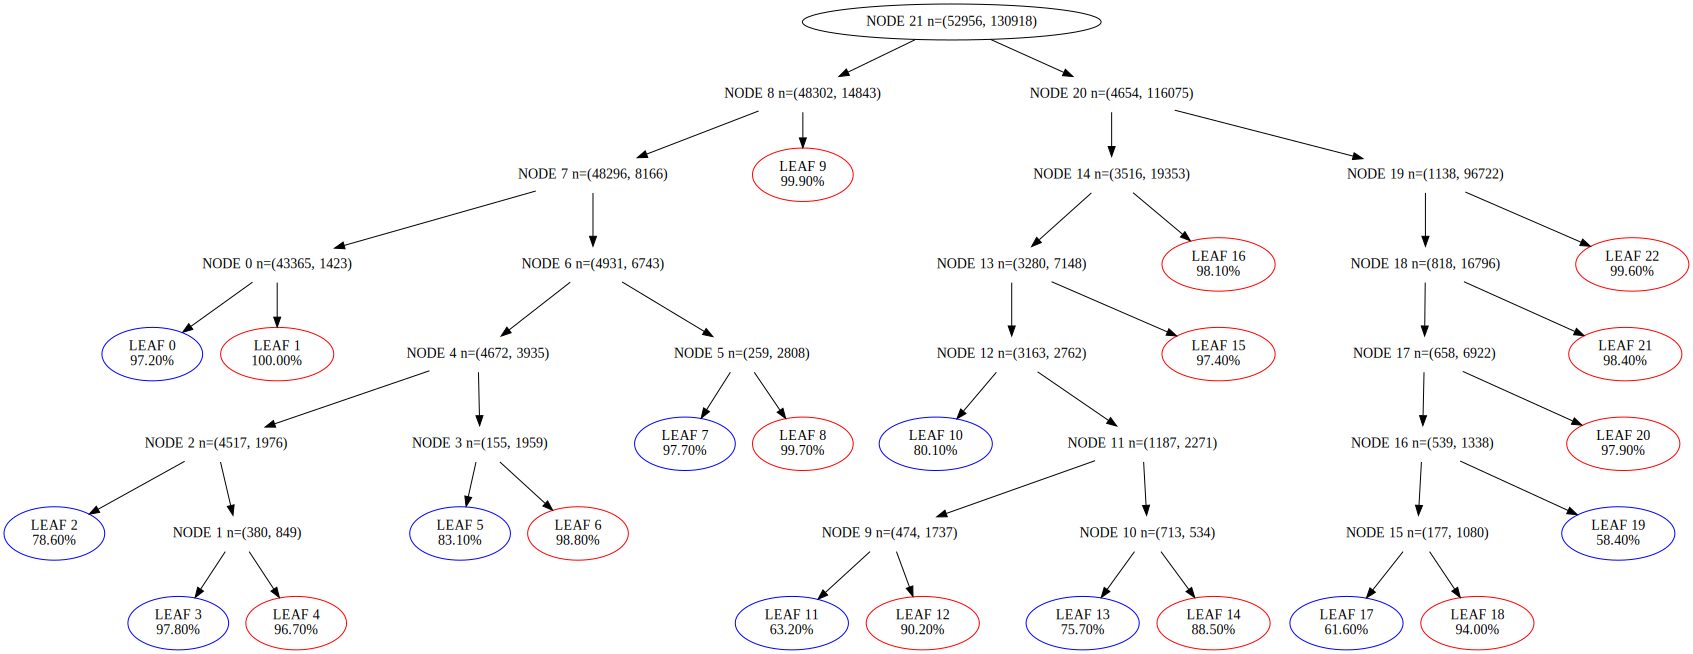

In [22]:
dot

Then convert an xarray into a numpy array:

In [23]:
def xr_to_cube(landsat):
    """Convert an Landsat xarray Dataset to a DataArray for WOfS."""
    return landsat[bands].to_array(dim="band")

In [24]:
landsat_cube = np.array(xr_to_cube(landsat))

Finally we can predict.

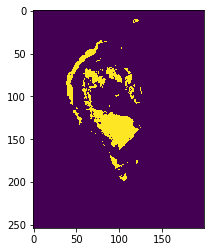

In [25]:
hard_predictions = wofs_tree.predict(landsat_cube)
plt.imshow(hard_predictions, interpolation='nearest')

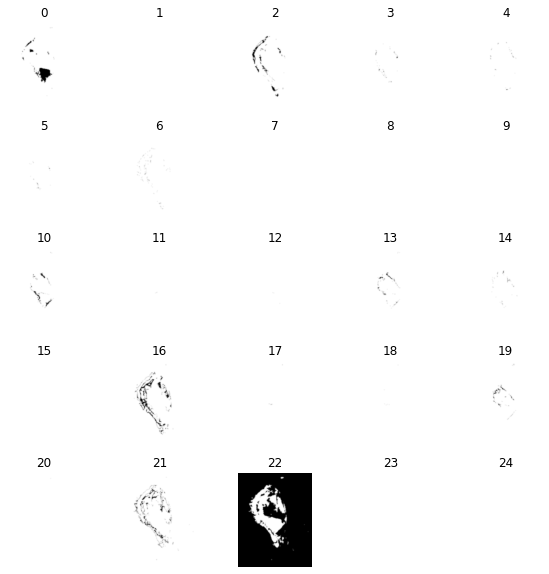

In [26]:
leaves = wofs_tree.get_leaf(landsat_cube)
plt.figure(figsize=(10, 10))
for i in range(5 ** 2):
    plt.subplot(5, 5, i + 1)
    plt.imshow(leaves == i, cmap='Greys', interpolation='gaussian')
    plt.axis('off')
    plt.title(i)

In [27]:
wofs_err = fuzzy_wofs.guess_noise(landsat_cube)

In [28]:
fuzzy_predictions = wofs_tree.fuzzy_predict(landsat_cube, wofs_err)

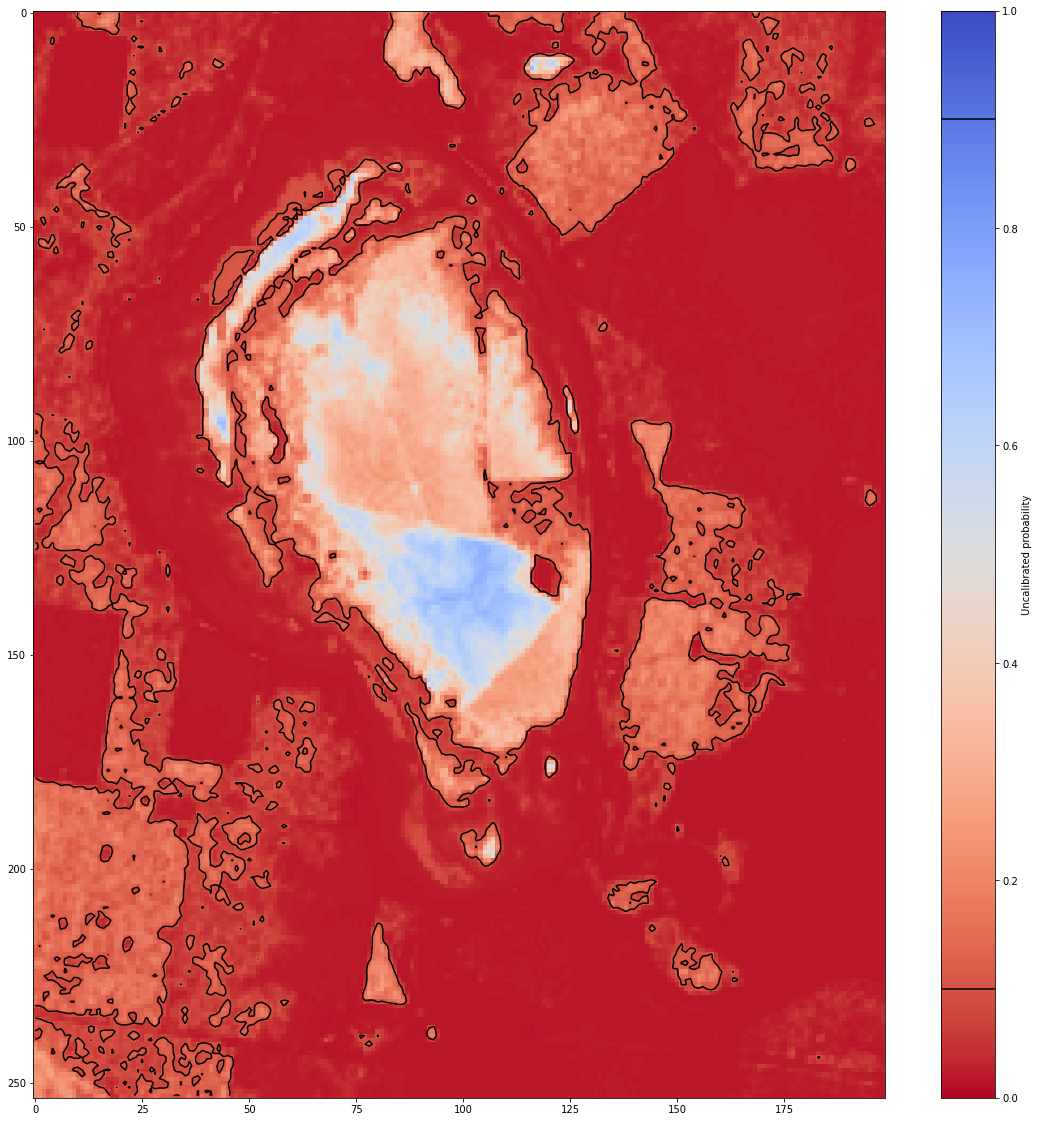

In [29]:
plt.figure(figsize=(20, 20))
plt.imshow(fuzzy_predictions, vmin=0, vmax=1, cmap='coolwarm_r', interpolation='nearest')
cb = plt.colorbar(label='Uncalibrated probability')
cb.ax.axhline(0.1, c='k')
cb.ax.axhline(0.9, c='k')
plt.contour(fuzzy_predictions, [0.1, 0.9], colors='k')

In [30]:
wofs_tree.to_string()

'((((0.97) * (1 - (erf((mu_ndi43 - 0.61) / sigma_ndi43) + 1) / 2) + (0.00) * (erf((mu_ndi43 - 0.61) / sigma_ndi43) + 1) / 2) * (1 - (erf((mu_tm7 - 323.5) / sigma_tm7) + 1) / 2) + ((((0.79) * (1 - (erf((mu_ndi43 - 0.22) / sigma_ndi43) + 1) / 2) + ((0.98) * (1 - (erf((mu_tm1 - 473.0) / sigma_tm1) + 1) / 2) + (0.03) * (erf((mu_tm1 - 473.0) / sigma_tm1) + 1) / 2) * (erf((mu_ndi43 - 0.22) / sigma_ndi43) + 1) / 2) * (1 - (erf((mu_ndi72 - -0.23) / sigma_ndi72) + 1) / 2) + ((0.83) * (1 - (erf((mu_tm1 - 379.0) / sigma_tm1) + 1) / 2) + (0.01) * (erf((mu_tm1 - 379.0) / sigma_tm1) + 1) / 2) * (erf((mu_ndi72 - -0.23) / sigma_ndi72) + 1) / 2) * (1 - (erf((mu_tm1 - 1400.5) / sigma_tm1) + 1) / 2) + ((0.98) * (1 - (erf((mu_ndi43 - -0.01) / sigma_ndi43) + 1) / 2) + (0.00) * (erf((mu_ndi43 - -0.01) / sigma_ndi43) + 1) / 2) * (erf((mu_tm1 - 1400.5) / sigma_tm1) + 1) / 2) * (erf((mu_tm7 - 323.5) / sigma_tm7) + 1) / 2) * (1 - (erf((mu_tm1 - 2083.5) / sigma_tm1) + 1) / 2) + (0.00) * (erf((mu_tm1 - 2083.5) / 

How does this compare to TCW, MNDWI, and the WOfS summary?

In [31]:
tcw = calculate_indices(da, index='TCW', collection='ga_ls_3')
mndwi = calculate_indices(da, index='MNDWI', collection='ga_ls_3')
wofs_summary = dc.load('wofs_filtered_summary', like=da.drop('time'))

/env/lib/python3.6/site-packages/datacube/api/core.py:345: UserWarning: Discarding nonzero nanoseconds in conversion
  query = Query(self.index, **kwargs)


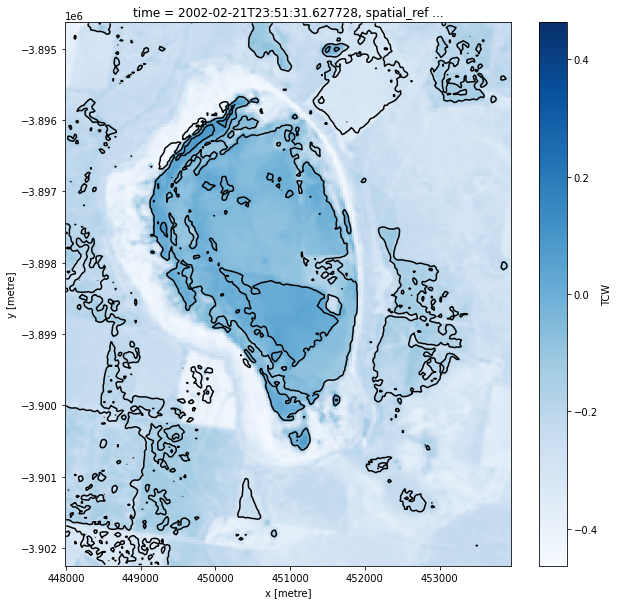

In [32]:
plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 1, 1)
tcw.TCW.isel(time=0).plot(ax=ax, cmap='Blues')
xr.DataArray(fuzzy_predictions, coords=tcw.isel(time=0).coords, dims=['y', 'x']).plot.contour(ax=ax, levels=[0.1, 0.5, 0.9], colors='k')

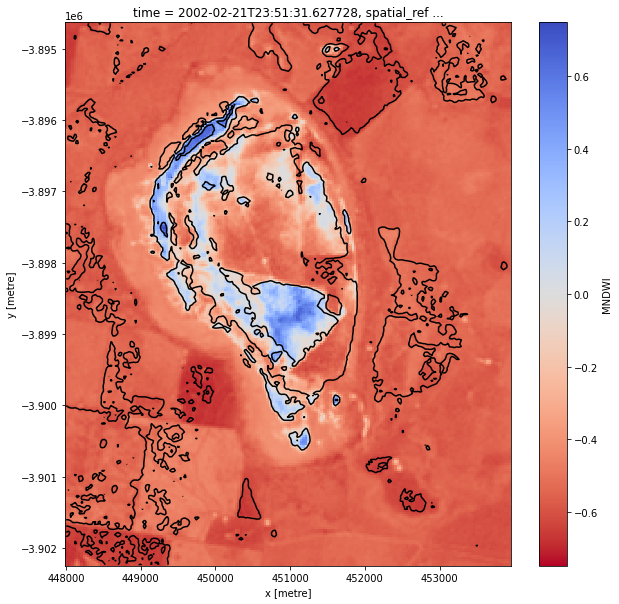

In [33]:
plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 1, 1)
mndwi.MNDWI.isel(time=0).plot(ax=ax, cmap='coolwarm_r')
xr.DataArray(fuzzy_predictions, coords=mndwi.isel(time=0).coords, dims=['y', 'x']).plot.contour(ax=ax, levels=[0.1, 0.5, 0.9], colors='k')

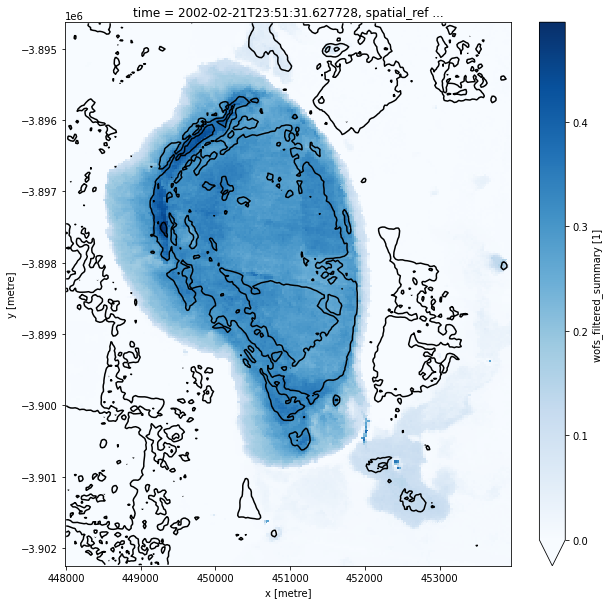

In [34]:
plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 1, 1)
wofs_summary.wofs_filtered_summary.isel(time=0).plot(ax=ax, cmap='Blues', vmin=0)
xr.DataArray(fuzzy_predictions, coords=mndwi.isel(time=0).coords, dims=['y', 'x']).plot.contour(ax=ax, levels=[0.1, 0.5, 0.9], colors='k')

In [35]:
colours = np.stack([
    fuzzy_predictions,
    tcw.isel(time=0).TCW,
    mndwi.isel(time=0).MNDWI,
])

In [36]:
im = np.transpose(colours, (1, 2, 0))

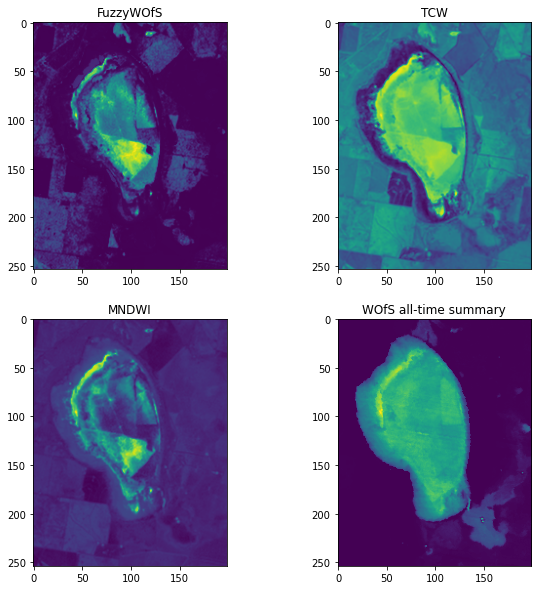

In [37]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.title('FuzzyWOfS')
plt.imshow(im[:, :, 0])
plt.subplot(2, 2, 2)
plt.title('TCW')
plt.imshow(im[:, :, 1])
plt.subplot(2, 2, 3)
plt.title('MNDWI')
plt.imshow(im[:, :, 2])
plt.subplot(2, 2, 4)
plt.title('WOfS all-time summary')
plt.imshow(wofs_summary.wofs_filtered_summary.isel(time=0), vmin=0)

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** November 2020

**Compatible datacube version:** 

In [38]:
print(datacube.__version__)

1.8.3


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)